In [1]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve, auc, f1_score
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import math
import joypy
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate 
from sklearn.feature_selection import SelectFromModel
from datetime import datetime
import matplotlib.ticker as ticker


# py -m pip install matplotlib

In [3]:
import pandas as pd

# Read data from file
data = pd.read_csv('Data_Original.txt', sep="\t")

# Convert date columns to datetime type
data['issue_date'] = pd.to_datetime(data['issue_date'], errors='coerce')
data['start_date'] = pd.to_datetime(data['start_date'], errors='coerce')
data['end_date'] = pd.to_datetime(data['end_date'], errors='coerce')
data['cancel_date'] = pd.to_datetime(data['cancel_date'], errors='coerce')
data['D_DRIVING_LICENSE'] = pd.to_datetime(data['D_DRIVING_LICENSE'], errors='coerce')

# Convert selected columns to category type
cols = ['PRODUCT', 'Country', 'IDD_CRM_ORGANIZATION_UNIT', 'PERSON_TYPE_CODE', 'Duration', 'vehicle_type', 'OBJECT_TYPE_NAME', 'Make', 'Model', 'Calculated_fleet', 'vehicle_type_group_mapped', 'vehicle_type_group']
for col in cols:
    data[col] = data[col].astype('category')

# Create a copy of the original data
data_1 = data.copy()

# Add 'Churn' column indicating if cancel_date is not NaN
data_1['Churn'] = data_1['cancel_date'].notna().astype(int)

# Add 'Renewal' column indicating if IsRenewed is not NaN
data_1['Renewal'] = data_1['IsRenewed'].notna().astype(int)

# Add 'Days_to_Cancel' column indicating the number of days between start_date and cancel_date
data_1['Days_to_Cancel'] = (data_1['cancel_date'] - data_1['start_date']).dt.days

# Add 'Policy_Duration' column indicating the number of days between start_date and end_date
data_1['Policy_Duration'] = (data_1['end_date'] - data_1['start_date']).dt.days

# Add 'Gender' column based on registration_code
def gender(registration_code):
    registration_code_str = str(registration_code)
    if registration_code_str[0].isdigit():
        first_digit = int(registration_code_str[0])
        if first_digit % 2 == 1:
            return 'Male'
        else:
            return 'Female'
    else:
        return 'Unknown'

data_1['Gender'] = data_1['REGISTRATION_CODE__GDPR'].apply(gender)

# Filter data for PRIVATE and CORPORATE
data_2 = data_1.copy()
df_private = data_2[data_2['PERSON_TYPE_CODE'] == 'P']
df_corporate = data_2[data_2['PERSON_TYPE_CODE'] == 'O']

# Filter data for MTPL and MOD within PRIVATE
df_private_MTPL = df_private[df_private['PRODUCT'] == 'MTPL']
df_private_MOD = df_private[df_private['PRODUCT'] == 'MOD']

# Drop duplicates from df_private_MTPL
df_private_MTPL.drop_duplicates(inplace=True)

# Remove selected columns from df_private_MTPL
cols_to_remove = ['PRODUCT', 'Country', 'policy_no', 'islfeet', 'Calculated_fleet', 'PERSON_TYPE_CODE',  'D_BIRTH', 'IsRenewed']
df_private_MTPL = df_private_MTPL.drop(columns=cols_to_remove)

# Convert selected columns to numeric type
cols_to_convert_numeric = ['Vehicle_age', 'GWP', 'Days_to_Cancel', 'Policy_Duration']
cols_to_convert_category = ['Churn', 'Renewal', 'Gender']
df_private_MTPL[cols_to_convert_numeric] = df_private_MTPL[cols_to_convert_numeric].apply(pd.to_numeric, errors='coerce')
df_private_MTPL[cols_to_convert_category] = df_private_MTPL[cols_to_convert_category].astype('category')


C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_13348\2325859263.py:4: DtypeWarning: Columns (7,10,11,12,20,22,23,27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data_Original.txt', sep="\t")
C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_13348\2325859263.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['D_DRIVING_LICENSE'] = pd.to_datetime(data['D_DRIVING_LICENSE'], errors='coerce')
C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_13348\2325859263.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_private_MTPL.drop_duplicates(inplace=True)


In [27]:
print(df_private_MTPL.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1397846 entries, 2037992 to 4559098
Data columns (total 29 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   issue_date                  1397846 non-null  datetime64[ns]
 1   start_date                  1397846 non-null  datetime64[ns]
 2   end_date                    1397846 non-null  datetime64[ns]
 3   cancel_date                 99309 non-null    datetime64[ns]
 4   IDD_CRM_ORGANIZATION_UNIT   1397846 non-null  category      
 5   Duration                    1397846 non-null  category      
 6   Vehicle_age                 1395823 non-null  float64       
 7   vehicle_type                1397846 non-null  category      
 8   OBJECT_TYPE_NAME            1397845 non-null  category      
 9   Make                        1397844 non-null  category      
 10  Model                       1397705 non-null  category      
 11  GWP                    

In [28]:
def extract_birth_date(registration_code):
    registration_code_str = str(registration_code)
    
    if registration_code_str.isdigit() and len(registration_code_str) == 11:
        year_digits = int(registration_code_str[1:3])
        month = int(registration_code_str[3:5])
        day = int(registration_code_str[5:7])
        
        if year_digits <= 10:
            birth_year = 2000 + year_digits
        else:
            birth_year = 1900 + year_digits
        
        try:
            birth_date = datetime(birth_year, month, day)
            return birth_date.strftime('%Y-%m-%d')
        except ValueError:
            return 'Unknown'
    else:
        return 'Unknown'


df_private_MTPL['Birth_Date'] = df_private_MTPL['REGISTRATION_CODE__GDPR'].apply(extract_birth_date)

# Calculate client age from birth date
df_private_MTPL['Birth_Date'] = pd.to_datetime(df_private_MTPL['Birth_Date'], errors='coerce')
df_private_MTPL['Client_Age'] = (df_private_MTPL['issue_date'] - df_private_MTPL['Birth_Date']).dt.days // 365


In [29]:
Make_counts = df_private_MTPL['ADR_CITY_NAME'].value_counts()

print("Frequency of values in the 'Make' variable:", Make_counts.head(10000))
pd.set_option('display.max_rows', None)


Frequency of values in the 'Make' variable: ADR_CITY_NAME
Vilnius                    196332
Kaunas                     143988
Klaipėda                    56267
Panevėžys                   55862
Šiauliai                    43421
Vilniaus r. sav.            29704
Kauno r. sav.               26605
Alytus                      23445
Vilniaus m. sav.            20907
Vilniaus rajono sav.        16261
Mažeikiai                   15861
Jonava                      15410
KAUNO RAJONO SAV.           15180
Tauragė                     14616
Marijampolė                 13399
Panevėžio r. sav.           13015
Telšiai                     12028
Utena                       11954
Alytaus r. sav.             11749
Vilkaviškis                 11597
Kauno m. sav.               11533
Plungė                      11326
Panevėžio rajono sav.       11183
Radviliškis                 10757
Klaipėdos r. sav.            9195
Ukmergė                      8517
Elektrėnai                   8460
VILKAVIŠKIO RAJONO SAV. 

In [30]:
missing_values_count = df_private_MTPL.isna().sum()

# Output the number of missing values in each column
print("Number of missing values in each column:")
print(missing_values_count)


Number of missing values in each column:
issue_date                          0
start_date                          0
end_date                            0
cancel_date                   1298537
IDD_CRM_ORGANIZATION_UNIT           0
Duration                            0
Vehicle_age                      2023
vehicle_type                        0
OBJECT_TYPE_NAME                    1
Make                                2
Model                             141
GWP                                 9
vehicle_type_group_mapped           9
vehicle_type_group                  9
REGISTRATION_CODE__GDPR             9
IDD_AGR_AGREEMENT                   9
ADR_REGION_NAME               1397841
ADR_CITY_NAME                   72044
IS_RESIDENT                   1326557
RECEIVE_MARKETING_MATERIAL      62901
D_DRIVING_LICENSE               80301
CLIENT_LOYALTY_PROGRAM          71415
ADR_FULL__GDPR                  11106
number_of_claims              1352985
Churn                               0
Renewal  

In [31]:
rows_with_na = df_private_MTPL[df_private_MTPL['Client_Age'].isna()]
pd.set_option('display.max_columns', None)

rows_with_na.head(5)


issue_date start_date   end_date cancel_date  \
2100594 2019-04-15 2019-05-06 2020-05-05         NaT   
2123664 2019-05-19 2019-05-20 2019-06-19         NaT   
2127388 2019-05-24 2019-06-10 2020-06-09         NaT   
2142636 2019-06-13 2019-06-22 2020-06-21         NaT   
2145434 2019-06-21 2019-06-21 2019-09-20         NaT   

        IDD_CRM_ORGANIZATION_UNIT Duration  Vehicle_age vehicle_type  \
2100594                       400     Long          9.0           A2   
2123664                       305    Short         24.0           A3   
2127388                       260     Long         12.0           A3   
2142636                       260     Long          9.0           A4   
2145434                       305    Short         24.0           A3   

                                          OBJECT_TYPE_NAME      Make  \
2100594  A Lengvasis automobilis / mikroautobusas iki 8...    TOYOTA   
2123664  A Lengvasis automobilis / mikroautobusas iki 8...        VW   
2127388  A Lengvasis automobilis / mikroautobusas iki 8...   HYUNDAI   
2142636  A Lengvasis automobilis / mikroautobusas iki 8...  CHRYSLER   
2145434  A Lengvasis automobilis / mikroautobusas iki 8...        VW   

               Model    GWP vehicle_type_group_mapped vehicle_type_group  \
2100594        AURIS   56.5               6) Personal                 M1   
2123664  TRANSPORTER   11.5               6) Personal                 M1   
2127388       TUCSON   77.0               6) Personal                 M1   
2142636   PT CRUISER  137.5               6) Personal                 M1   
2145434  TRANSPORTER   23.5               6) Personal                 M1   

        REGISTRATION_CODE__GDPR  IDD_AGR_AGREEMENT ADR_REGION_NAME  \
2100594             X0000141959         23155793.0             NaN   
2123664               153720380         23387460.0             NaN   
2127388                19630918         23427928.0             NaN   
2142636              1966-03-13         23598733.0             NaN   
2145434               153720380         23630934.0             NaN   

        ADR_CITY_NAME IS_RESIDENT RECEIVE_MARKETING_MATERIAL  \
2100594       Vilnius         NaN                        Yes   
2123664           NaN         NaN                         No   
2127388       Vilnius         NaN                          ?   
2142636       Vilnius         NaN                          ?   
2145434           NaN         NaN                         No   

        D_DRIVING_LICENSE CLIENT_LOYALTY_PROGRAM               ADR_FULL__GDPR  \
2100594        1967-01-01                     R1           Didlaukio g. 51-38   
2123664               NaT                     R3  Alytaus m., Alytaus m. sav.   
2127388        1982-01-01                     R1            P. Rimšos g.13-15   
2142636        1997-01-01                     R2            Šv. Stepono g. 21   
2145434               NaT                     R3  Alytaus m., Alytaus m. sav.   

         number_of_claims Churn Renewal  Days_to_Cancel  Policy_Duration  \
2100594               NaN     0       1             NaN            365.0   
2123664               NaN     0       0             NaN             30.0   
2127388               NaN     0       1             NaN            365.0   
2142636               NaN     0       1             NaN            365.0   
2145434               NaN     0       1             NaN             91.0   

          Gender Birth_Date  Client_Age  
2100594  Unknown        NaT         NaN  
2123664     Male        NaT         NaN  
2127388     Male        NaT         NaN  
2142636     Male        NaT         NaN  
2145434     Male        NaT         NaN

In [32]:
num_rows = df_private_MTPL.shape[0]
print("Number of rows in df:", num_rows)

Number of rows in df: 1397846


In [33]:
column_name = 'Client_Age'  # Replace 'your_column_name' with the actual column name

# Count the number of NA values in the specified column
na_count = df_private_MTPL[column_name].isna().sum()

# Calculate the percentage of NA values compared to the total number of rows in the column
total_rows = len(df_private_MTPL[column_name])
percentage_na = (na_count / total_rows) * 100

print("Percentage of NA values in column '{}': {:.2f}%".format(column_name, percentage_na))


Percentage of NA values in column 'Client_Age': 6.18%


In [34]:
# Pasiziurime, kiek automobiliu markiu yra

Make_counts = df_private_MTPL['Make'].value_counts()

print("Frequency of values in the 'Make' variable:")
pd.set_option('display.max_rows', None)

# parasome if'a, kad paimti tik pagrindines markes, o kitas imesti kaip Other:
brands_to_keep = ['BMW', 'VW', 'AUDI', 'TOYOTA', 'OPEL', 'VOLVO', 'FORD', 'MERCEDES BENZ', 
                  'HONDA', 'PEUGEOT', 'NISSAN', 'CITROEN', 'RENAULT', 'MAZDA', 'CHRYSLER', 
                  'MITSUBISHI', 'SUBARU', 'SKODA', 'HYUNDAI', 'KIA', 'SUZUKI', 'LEXUS']

df_private_MTPL['Make'] = df_private_MTPL['Make'].astype(str)

# Replace values not in the list with 'Other'
df_private_MTPL['Make'] = df_private_MTPL['Make'].apply(lambda x: x if x in brands_to_keep else 'Other')

# Convert 'Make' column back to categorical type
df_private_MTPL['Make'] = df_private_MTPL['Make'].astype('category')



# Tvarkome praleistas reiksmes:
#df_private_MTPL['ADR_CITY_NAME'] = df_private_MTPL['ADR_CITY_NAME'].fillna('Unknown')


# parasome if'a, kad paimti tik pagrindinius miestus, o kitus imesti kaip Other:
Cities_to_keep = ['Vilnius', 'Kaunas', 'Panevėžys', 'Klaipėda', 'Šiauliai', 'Alytus', 'Marijampolė', 'Mažeikiai', 'Jonava', 
    'Telšiai', 'Vilniaus m. sav.', 'Kauno m. sav.', 'Panevėžio m. sav.', 'Klaipėdos m. sav.', 'Alytaus m. sav.', 
    'Kauno r. sav.', 'Vilniaus r. sav.', 'Alytaus r. sav.', 'Panevėžio r. sav.', 'KAUNO RAJONO SAV.', 
    'Vilniaus rajono sav.', 'Klaipėdos r. sav.', 'Marijampolės sav.', 'Šiaulių m. sav.', 'Klaipėdos rajono sav.', 
    'Šiaulių r. sav.', 'ALYTAUS RAJONO SAV.', 'Panevėžio rajono sav.', 'Šiaulių raj.' #, 'Unknown'
]

df_private_MTPL['ADR_CITY_NAME'] = df_private_MTPL['ADR_CITY_NAME'].astype(str)

# Replace values not in the list with 'Other'
df_private_MTPL['ADR_CITY_NAME'] = df_private_MTPL['ADR_CITY_NAME'].apply(lambda x: x if x in Cities_to_keep else 'Other')

city_mapping = {
    'Vilnius': 'Vilnius', 
    'Kaunas': 'Kaunas', 
    'Panevėžys': 'Panevėžys',
    'Klaipėda':'Klaipėda',
    'Šiauliai':'Šiauliai',
    'Alytus':'Alytus',
    'Marijampolė':'Marijampolė',
    'Mažeikiai':'Mažeikiai',
    'Jonava':'Jonava', 
    'Telšiai':'Telšiai',
    'Vilniaus m. sav.': 'Vilnius',
    'Kauno m. sav.': 'Kaunas',
    'Panevėžio m. sav.': 'Panevėžys',
    'Klaipėdos m. sav.': 'Klaipėda',
    'Alytaus m. sav.': 'Alytus',
    'Kauno r. sav.': 'Kauno rajonas',
    'Vilniaus r. sav.': 'Vilniaus rajonas',
    'Alytaus r. sav.': 'Alytaus rajonas',
    'Panevėžio r. sav.': 'Panevėžio rajonas',
    'KAUNO RAJONO SAV.': 'Kauno rajonas',
    'Vilniaus rajono sav.': 'Vilniaus rajonas',
    'Klaipėdos r. sav.': 'Klaipėdos rajonas',
    'Marijampolės sav.': 'Marijampolės rajonas',
    'Šiaulių m. sav.': 'Šiauliai',
    'Klaipėdos rajono sav.': 'Klaipėdos rajonas',
    'Šiaulių r. sav.': 'Šiaulių rajonas',
    'ALYTAUS RAJONO SAV.': 'Alytaus rajonas',
    'Panevėžio rajono sav.': 'Panevėžio rajonas',
    'Šiaulių raj.': 'Šiaulių rajonas',
    #'Unknown': 'Unknown',
    'Other': 'Other'
}

df_private_MTPL['City'] = df_private_MTPL['ADR_CITY_NAME'].map(city_mapping)



####

#df_private_MTPL['IS_RESIDENT'] = df_private_MTPL['IS_RESIDENT'].replace({'N': 'False', 'Y': 'True'})
# df_private_MTPL['IS_RESIDENT'] = df_private_MTPL['IS_RESIDENT'].fillna('Unknown')



#df_private_MTPL['RECEIVE_MARKETING_MATERIAL'] = df_private_MTPL['RECEIVE_MARKETING_MATERIAL'].replace({'N': 'No', 'Y': 'Yes', '?': np.nan, 'Unkn': np.nan})
#df_private_MTPL['RECEIVE_MARKETING_MATERIAL'] = df_private_MTPL['RECEIVE_MARKETING_MATERIAL'].fillna('Unknown')



df_private_MTPL['D_DRIVING_LICENSE'] = pd.to_datetime(df_private_MTPL['D_DRIVING_LICENSE'], errors='coerce')
df_private_MTPL['issue_date'] = pd.to_datetime(df_private_MTPL['issue_date'], errors='coerce')



df_private_MTPL['Years_of_driving'] = (df_private_MTPL['issue_date'].dt.year - df_private_MTPL['D_DRIVING_LICENSE'].dt.year)
#df_private_MTPL['Years_of_driving'] = (df_private_MTPL['issue_date'] - df_private_MTPL['D_DRIVING_LICENSE']).dt.days // 365

# df_private_MTPL['Vehicle_age'] = df_private_MTPL['Vehicle_age'].fillna(-1)

# df_private_MTPL['CLIENT_LOYALTY_PROGRAM'] = df_private_MTPL['CLIENT_LOYALTY_PROGRAM'].fillna('Unknown')

#df_private_MTPL['Client_Age'] = df_private_MTPL['Client_Age'].fillna(-1)



df_private_MTPL['number_of_claims'] = df_private_MTPL['number_of_claims'].fillna(0)



# df_private_MTPL['Years_of_driving'] = df_private_MTPL['Years_of_driving'].fillna(-1)



# Istriname nereikalingus stulpelius:
df_private_MTPL = df_private_MTPL.drop(['start_date', 'end_date', 'cancel_date', 'ADR_CITY_NAME', 'Model', 'IDD_AGR_AGREEMENT', 'vehicle_type_group', 
                                        'CLIENT_LOYALTY_PROGRAM', 'RECEIVE_MARKETING_MATERIAL', 'OBJECT_TYPE_NAME', 'IDD_CRM_ORGANIZATION_UNIT', 'IS_RESIDENT', 'REGISTRATION_CODE__GDPR', 'issue_date', 'D_DRIVING_LICENSE', 'ADR_REGION_NAME', 'Birth_Date',  'ADR_FULL__GDPR', 'Days_to_Cancel'], axis=1)



# jei naudojam 2022 m data

#df_private_MTPL = df_private_MTPL.dropna()


Frequency of values in the 'Make' variable:


In [35]:
missing_values_count = df_private_MTPL.isna().sum()

# Output the number of missing values in each column
print("Number of missing values in each column:")
print(missing_values_count)

# Galim atmesti lojalumo programa, is resident, marketing material.


Number of missing values in each column:
Duration                         0
Vehicle_age                   2023
vehicle_type                     0
Make                             0
GWP                              9
vehicle_type_group_mapped        9
number_of_claims                 0
Churn                            0
Renewal                          0
Policy_Duration                  0
Gender                           0
Client_Age                   86377
City                             0
Years_of_driving             80301
dtype: int64


In [36]:
df_private_MTPL = df_private_MTPL.dropna()


In [37]:
df_private_MTPL['Vehicle_age'] = pd.to_numeric(df_private_MTPL['Vehicle_age'], errors='coerce')
df_private_MTPL['GWP'] = pd.to_numeric(df_private_MTPL['GWP'], errors='coerce')
df_private_MTPL['number_of_claims'] = pd.to_numeric(df_private_MTPL['number_of_claims'], errors='coerce')
df_private_MTPL['Client_Age'] = pd.to_numeric(df_private_MTPL['Client_Age'], errors='coerce')
df_private_MTPL['Policy_Duration'] = pd.to_numeric(df_private_MTPL['Policy_Duration'], errors='coerce')
df_private_MTPL['Years_of_driving'] = pd.to_numeric(df_private_MTPL['Years_of_driving'], errors='coerce')

#df_private_MTPL['IDD_CRM_ORGANIZATION_UNIT'] = pd.Categorical(df_private_MTPL['IDD_CRM_ORGANIZATION_UNIT'])
df_private_MTPL['Duration'] = pd.Categorical(df_private_MTPL['Duration'])
df_private_MTPL['vehicle_type'] = pd.Categorical(df_private_MTPL['vehicle_type'])
#df_private_MTPL['OBJECT_TYPE_NAME'] = pd.Categorical(df_private_MTPL['OBJECT_TYPE_NAME'])
df_private_MTPL['Make'] = pd.Categorical(df_private_MTPL['Make'])
df_private_MTPL['vehicle_type_group_mapped'] = pd.Categorical(df_private_MTPL['vehicle_type_group_mapped'])
df_private_MTPL['City'] = pd.Categorical(df_private_MTPL['City'])
# df_private_MTPL['IS_RESIDENT'] = pd.Categorical(df_private_MTPL['IS_RESIDENT'])
# df_private_MTPL['RECEIVE_MARKETING_MATERIAL'] = pd.Categorical(df_private_MTPL['RECEIVE_MARKETING_MATERIAL'])
# df_private_MTPL['CLIENT_LOYALTY_PROGRAM'] = pd.Categorical(df_private_MTPL['CLIENT_LOYALTY_PROGRAM'])
df_private_MTPL['Churn'] = pd.Categorical(df_private_MTPL['Churn'])
df_private_MTPL['Renewal'] = pd.Categorical(df_private_MTPL['Renewal'])
df_private_MTPL['Gender'] = pd.Categorical(df_private_MTPL['Gender'])


C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_33988\1106376691.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=categorical_column, data=df_private_MTPL, palette="muted", edgecolor=".9")


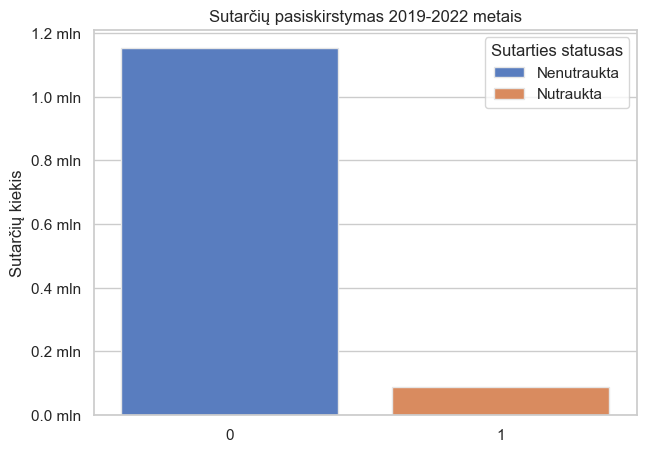

In [38]:
categorical_column = 'Churn'

sns.set(style="whitegrid")

plt.figure(figsize=(7, 5))
sns.countplot(x=categorical_column, data=df_private_MTPL, palette="muted", edgecolor=".9")

# Add legend
legend_labels = {0: "Nenutraukta", 1: "Nutraukta"}
plt.legend(title="Sutarties statusas", labels=legend_labels.values(), loc="upper right")

plt.xlabel("")
plt.ylabel("Sutarčių kiekis")
plt.title("Sutarčių pasiskirstymas 2019-2022 metais")

plt.xticks(rotation=0)

# Format y-axis labels in millions
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f} mln'.format(x / 1e6))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()


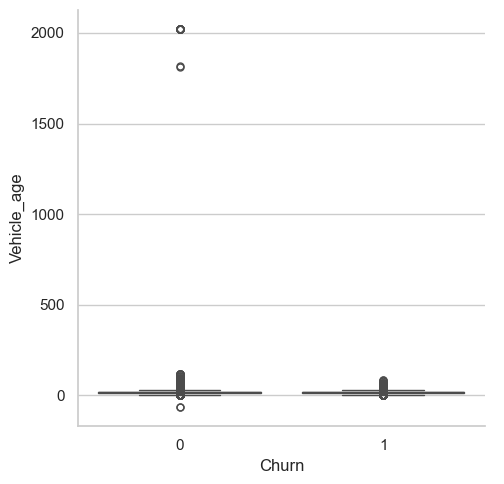

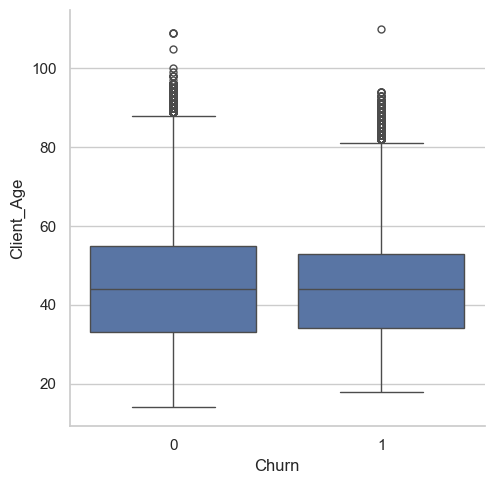

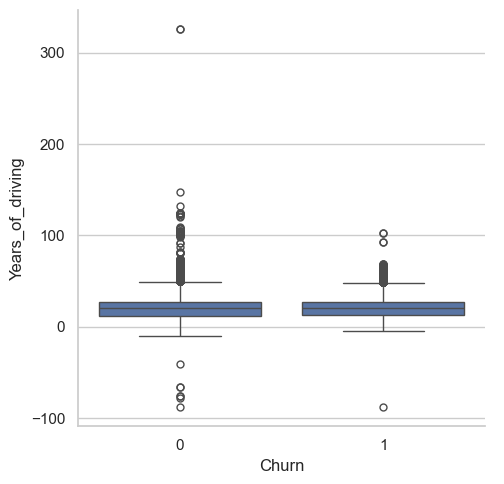

In [39]:
# zinome, kad bus outlieriu sitose stulpeliuose, todel pasiplotinam paziureti:

sns.catplot(data=df_private_MTPL, x="Churn", y='Vehicle_age', kind="box")

sns.catplot(data=df_private_MTPL, x="Churn", y='Client_Age', kind="box")

sns.catplot(data=df_private_MTPL, x="Churn", y='Years_of_driving', kind="box")


In [40]:
df_private_MTPL2 = df_private_MTPL

In [41]:
# Istriname, jei vehicle age <0

df_private_MTPL2 = df_private_MTPL2[df_private_MTPL2['Vehicle_age'] >= 0]



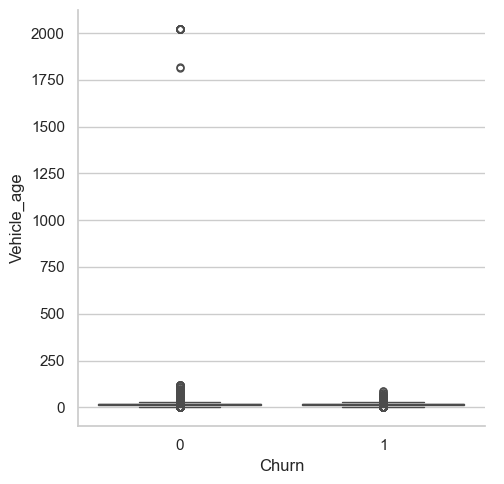

In [42]:
sns.catplot(data=df_private_MTPL2, x="Churn", y='Vehicle_age', kind="box")

In [43]:
sorted_df = df_private_MTPL2.sort_values(by='Vehicle_age')
print("First 10 values of Vehicle_age (ascending):")
print(sorted_df['Vehicle_age'].head(10))

print("\nLast 10 values of Vehicle_age (ascending):")
print(sorted_df['Vehicle_age'].tail(50))


First 10 values of Vehicle_age (ascending):
3606726    0.0
3884014    0.0
4258799    0.0
2971162    0.0
4516715    0.0
4189164    0.0
3601862    0.0
2378280    0.0
2525604    0.0
4516714    0.0
Name: Vehicle_age, dtype: float64

Last 10 values of Vehicle_age (ascending):
4016732      83.0
3009581      83.0
3009580      83.0
4297750      83.0
4297751      83.0
2909621      84.0
4179038      84.0
2909620      84.0
3222564      85.0
3222565      85.0
3244302      86.0
4140988      87.0
3975770      87.0
3975771      87.0
2592654      87.0
2592655      87.0
3075996      91.0
4065866      95.0
4065867      95.0
2423705      98.0
2423704      98.0
4271956     107.0
3880545     108.0
3880544     108.0
2093284     119.0
2145934     119.0
2101906     119.0
2145324     119.0
2164744     119.0
2118082     119.0
2088154     119.0
2352022     120.0
2350770     120.0
2361062    1814.0
2352260    1816.0
2322580    2020.0
2957375    2021.0
2957374    2021.0
3093192    2021.0
2963585    2021.0
2987549 

In [44]:
target_class = 'Churn'

column_of_interest1 = 'Vehicle_age'

z_scores1 = (df_private_MTPL2[column_of_interest1] - df_private_MTPL2[column_of_interest1].mean()) / df_private_MTPL2[column_of_interest1].std()

threshold_vehicle_age = 7

outlier_rows_vehicle_age = df_private_MTPL2[abs(z_scores1) > threshold_vehicle_age]

df_private_MTPL2 = df_private_MTPL2.drop(outlier_rows_vehicle_age.index)

print("Rows with outliers in vehicle age:")
print(outlier_rows_vehicle_age)

print("Count:", outlier_rows_vehicle_age.shape[0])


Rows with outliers in vehicle age:
        Duration  Vehicle_age vehicle_type     Make     GWP  \
2088154    Short        119.0           B1  PEUGEOT    7.50   
2093284    Short        119.0           B2    Other    3.00   
2101906    Short        119.0           B1    Other   16.50   
2118082    Short        119.0           B2    Other    3.00   
2145324    Short        119.0           B1    Other    7.50   
2145934    Short        119.0           B2    Other    3.00   
2164744    Short        119.0           B2    Other    3.00   
2322580    Short       2020.0           B1    Other    3.00   
2350770     Long        120.0           F4    Other    4.00   
2352022     Long        120.0           F4    Other    4.00   
2352260    Short       1816.0           A5    LEXUS   26.50   
2361062     Long       1814.0           A2  PEUGEOT  149.00   
2423704    Short         98.0           A1    Other    4.41   
2423705    Short         98.0           A1    Other    4.40   
2592654     Long    

client age

In [45]:
df_private_MTPL3 = df_private_MTPL2

In [46]:
df_private_MTPL3 =df_private_MTPL3[(df_private_MTPL3['Client_Age'] >= 18) & (df_private_MTPL3['Client_Age'] <= 100)]

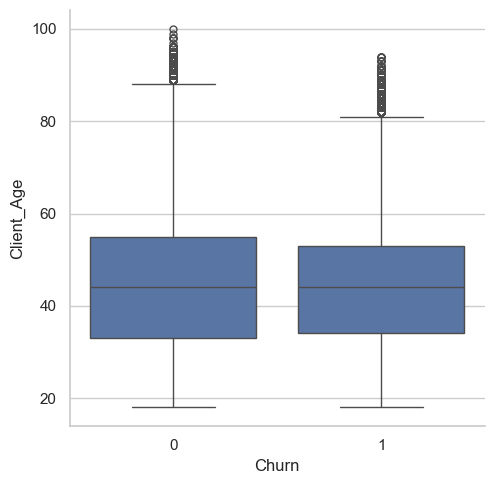

In [47]:
sns.catplot(data=df_private_MTPL3, x="Churn", y='Client_Age', kind="box")

In [48]:
df_private_MTPL4 = df_private_MTPL3

In [49]:
df_private_MTPL4 =df_private_MTPL4[(df_private_MTPL4['Years_of_driving'] >= 0) & (df_private_MTPL4['Years_of_driving'] <= 82)]

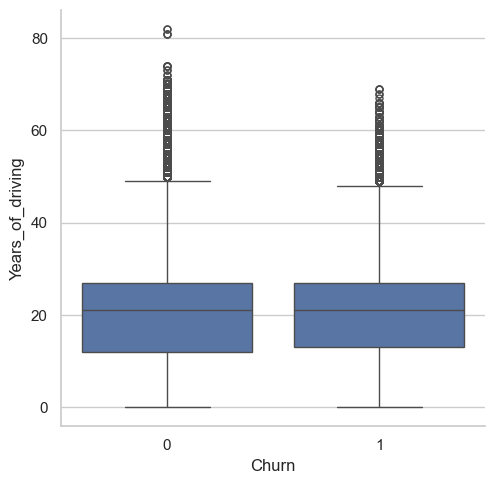

In [50]:
sns.catplot(data=df_private_MTPL4, x="Churn", y='Years_of_driving', kind="box")

C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_33988\1258041751.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=categorical_column, data=df_private_MTPL4, palette="muted", edgecolor=".9")


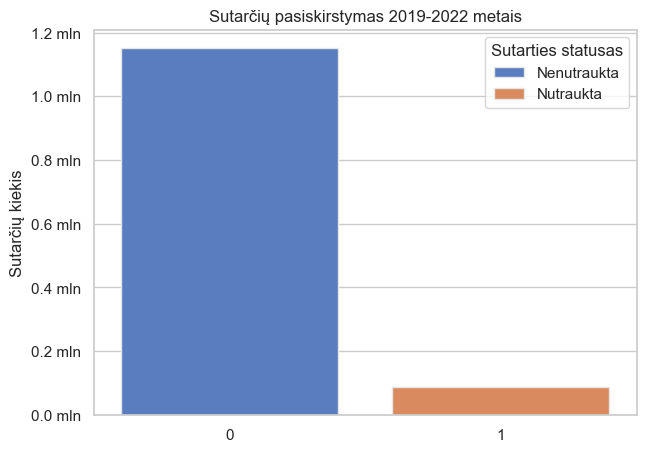

In [51]:
categorical_column = 'Churn'

sns.set(style="whitegrid")

plt.figure(figsize=(7, 5))
sns.countplot(x=categorical_column, data=df_private_MTPL4, palette="muted", edgecolor=".9")

# Add legend
legend_labels = {0: "Nenutraukta", 1: "Nutraukta"}
plt.legend(title="Sutarties statusas", labels=legend_labels.values(), loc="upper right")

plt.xlabel("")
plt.ylabel("Sutarčių kiekis")
plt.title("Sutarčių pasiskirstymas 2019-2022 metais")

plt.xticks(rotation=0)

# Format y-axis labels in millions
formatter = ticker.FuncFormatter(lambda x, pos: '{:.1f} mln'.format(x / 1e6))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_33988\232011652.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_private_MTPL4, x="Churn", y='GWP', palette="muted")


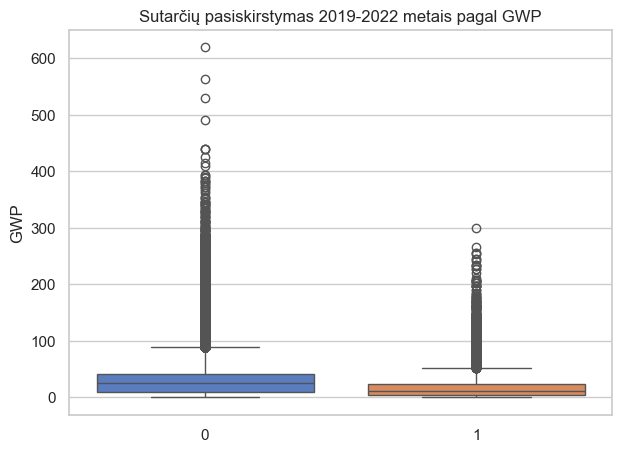

In [52]:
sns.set(style="whitegrid")

plt.figure(figsize=(7, 5))
sns.boxplot(data=df_private_MTPL4, x="Churn", y='GWP', palette="muted")

plt.xlabel("")
plt.ylabel("GWP")
plt.title("Sutarčių pasiskirstymas 2019-2022 metais pagal GWP")

plt.xticks(rotation=0)

plt.show()


C:\Users\evelina.voleiso\AppData\Local\Temp\ipykernel_33988\3202219731.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_private_MTPL4, x="Churn", y='number_of_claims', palette="muted")


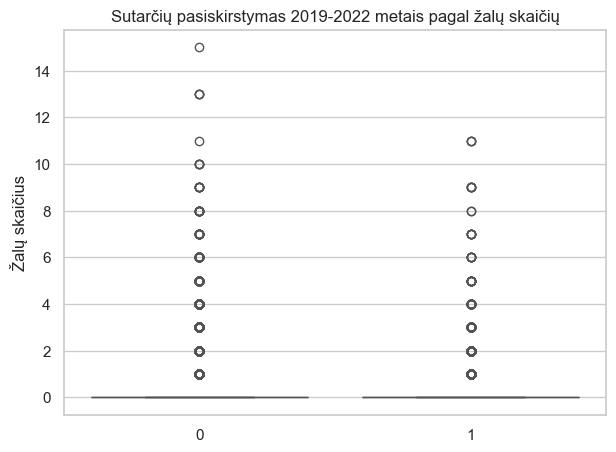

In [53]:
sns.set(style="whitegrid")

plt.figure(figsize=(7, 5))
sns.boxplot(data=df_private_MTPL4, x="Churn", y='number_of_claims', palette="muted")

plt.xlabel("")
plt.ylabel("Žalų skaičius")
plt.title("Sutarčių pasiskirstymas 2019-2022 metais pagal žalų skaičių")

plt.xticks(rotation=0)

plt.show()


In [54]:
df_private_MTPL4.head(5)

Duration  Vehicle_age vehicle_type     Make    GWP  \
2037992    Short         17.0           A5      BMW  23.85   
2037994     Long          8.0           A3     FORD  45.00   
2037996    Short         16.0           A4      BMW  15.00   
2037998    Short         18.0           A2  PEUGEOT   7.50   
2038000     Long         12.0           A4    VOLVO  42.50   

        vehicle_type_group_mapped  number_of_claims Churn Renewal  \
2037992               6) Personal               0.0     0       0   
2037994               6) Personal               0.0     0       1   
2037996               6) Personal               0.0     0       0   
2037998               6) Personal               0.0     0       0   
2038000               6) Personal               0.0     0       1   

         Policy_Duration  Gender  Client_Age       City  Years_of_driving  
2037992             88.0  Female        35.0    Vilnius              13.0  
2037994            364.0  Female        36.0  Panevėžys               8.0  
2037996             30.0    Male        25.0     Kaunas               6.0  
2037998             30.0    Male        36.0   Klaipėda              19.0  
2038000            364.0  Female        37.0  Panevėžys              17.0

In [55]:
summary_stats = df_private_MTPL4.describe()
pd.options.display.float_format = '{:.2f}'.format
summary_stats


Vehicle_age        GWP  number_of_claims  Policy_Duration  Client_Age  \
count   1239880.00 1239880.00        1239880.00       1239880.00  1239880.00   
mean         16.01      27.99              0.04           237.48       45.23   
std           6.42      24.11              0.24           147.92       14.24   
min           0.00      -0.01              0.00             0.00       18.00   
25%          13.00       8.44              0.00            89.00       33.00   
50%          16.00      23.65              0.00           364.00       44.00   
75%          20.00      39.78              0.00           364.00       55.00   
max          84.00     619.50             15.00           365.00      100.00   

       Years_of_driving  
count        1239880.00  
mean              20.76  
std               11.14  
min                0.00  
25%               12.00  
50%               21.00  
75%               27.00  
max               82.00

In [56]:
####

churn_counts = df_private_MTPL4['Churn'].value_counts()
total_samples = churn_counts.sum()

churn_percentage = churn_counts / total_samples * 100
print(churn_percentage)


Churn
0   92.85
1    7.15
Name: count, dtype: float64


In [57]:
df_private_MTPL4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1239880 entries, 2037992 to 4559098
Data columns (total 14 columns):
 #   Column                     Non-Null Count    Dtype   
---  ------                     --------------    -----   
 0   Duration                   1239880 non-null  category
 1   Vehicle_age                1239880 non-null  float64 
 2   vehicle_type               1239880 non-null  category
 3   Make                       1239880 non-null  category
 4   GWP                        1239880 non-null  float64 
 5   vehicle_type_group_mapped  1239880 non-null  category
 6   number_of_claims           1239880 non-null  float64 
 7   Churn                      1239880 non-null  category
 8   Renewal                    1239880 non-null  category
 9   Policy_Duration            1239880 non-null  float64 
 10  Gender                     1239880 non-null  category
 11  Client_Age                 1239880 non-null  float64 
 12  City                       1239880 non-null  category
 

In [58]:
# taisom kategorinius kintamuosius

values_to_keep = ['Long', 'Short']
df_private_MTPL4 = df_private_MTPL4[df_private_MTPL4['Duration'].isin(values_to_keep)]

values_to_keep2 = ['A3', 'A4', 'A2', 'A5', 'A1', 'B2', 'C6', 'F4', 'C3', 'B1', 'F13', 'F8', 'F12', 'F14', 'F11', 'C5', 'A', 'C4', 'F5', 'F10', 'F7', 'F6', 'F9', 'E1', 'F1', 'E2', 'F2', 'C1', 'B']
df_private_MTPL4 = df_private_MTPL4[df_private_MTPL4['vehicle_type'].isin(values_to_keep2)]




In [59]:
df_private_MTPL5 = df_private_MTPL4

numerical_columns = ['Vehicle_age', 'GWP', 'number_of_claims', 'Policy_Duration', 'Client_Age', 'Years_of_driving']

scaler = MinMaxScaler()
df_private_MTPL5[numerical_columns] = scaler.fit_transform(df_private_MTPL5[numerical_columns])

In [60]:
df_private_MTPL6 = df_private_MTPL5

In [61]:
#df_private_MTPL6 = df_private_MTPL5

categorical_columns = ['Duration', 'vehicle_type', 'Make', 'vehicle_type_group_mapped', 'Renewal', 'Gender', 'City']

df_private_MTPL6 = pd.get_dummies(df_private_MTPL6, columns=categorical_columns)
